In [10]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import timeit
from astropy.stats import LombScargle
%matplotlib inline

# The Lomb Scargle Algorithm
Alex Matheson and Austin Nhung

## Introduction

The Lomb-Scargle algorithm is a way of finding periodicity in data not by transformation, but by choosing a finite set of frequencies to act as a basis, and then fitting the data to the basis. 

In [6]:
def lomb_scargle(amp, 
                 time, 
                 oversample,
                 f_max = 100.):
    
    """Computes the lomb-scargle periodigram for a set of time and amplitude data
    INPUT:  amp        = amplitude data of the signal of interest
            time       = time points at which amp was obtained
            oversample = the factor to oversample past the nyquist frequency
            f_max      = the maximum frequncy to consider fitting to
    OUTPUT: freq       = the frequency grid used
            ps         = the power spectrum at points specified in freq""" 
    
    #Need to normalize the input data
    mean = np.mean(amp)
    amp = amp - mean
    duration = np.amax(time) - np.amin(time)
    
    #Determine the frequency grid
    f_min = 1. / duration                          #Minimum frequency is equivalent to the period of the whole system
    num_f = int(oversample * duration * f_max)     #Oversampling the nyquist frequency
    freq = np.linspace(f_min, f_max, num_f)
    
    #Calculate the value of tau at all frequencies
    tau = np.zeros_like(freq)
    omega = 2 * np.pi * freq                       #Calculate quantities separately for ease of readibility, redundancy
    for i, val in enumerate(omega):
        s_tau = np.sum( np.sin(2 * val * time) )
        c_tau = np.sum( np.cos(2 * val * time) )
        tau[i] = (1. / (2 * val)) * np.arctan( s_tau / c_tau )
    
    #Calculate the power spectrum at each frequency
    ps = np.zeros_like(freq)
    for i, f in enumerate(freq):
        om = 2 * np.pi * f
        c  = np.cos( om * ( time - tau[i] ) )      #Calculate each term of the power equation separately
        s  = np.sin( om * ( time - tau[i] ) )
        sc = np.sum(amp * c)**2
        ss = np.sum(amp * s)**2
        c2 = np.sum( c**2 )
        s2 = np.sum( s**2 )
        
        ps[i] = 0.5 * (  sc / c2 + ss / s2 )    
    
    return freq, ps

def phase(time,
          period):
     
    phase = np.zeros_like(time)
    phase = np.mod( time/period, 1 )
    return phase
    

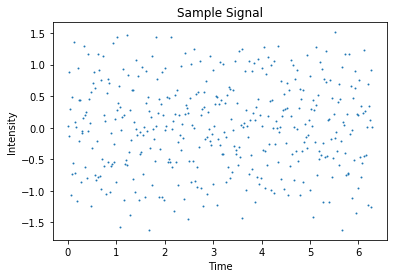

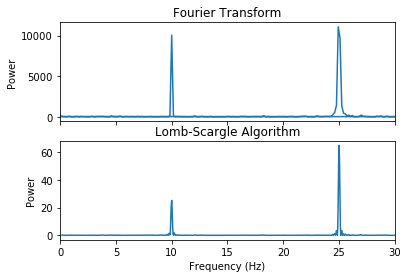

In [12]:
#Testing the function using both FFT and lomb-scargle for a simple example

t = np.linspace(0, 2*np.pi, 400)
v = 0.5 * np.sin(2 * np.pi * 10 * t) + 0.8 * np.sin(2 * np.pi * 25 * t) + 0.2 * np.random.normal(size=400)

v_fft = np.abs(np.fft.fft(v))
f_fft = np.fft.fftfreq(len(t), t[1] - t[0])

f_ls, v_ls = lomb_scargle(v, t, 4, f_max=30.)

plt.figure(0)
plt.scatter(t, v, s=0.9)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Sample Signal')

plt.figure(1)
g, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(f_fft, v_fft**2)
ax[1].plot(f_ls, v_ls)
ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
ax[0].set_ylabel('Power')
ax[1].set_ylabel('Power')
ax[1].set_xlabel('Frequency (Hz)')
ax[0].set_title('Fourier Transform')
ax[1].set_title('Lomb-Scargle Algorithm')

In [14]:
#Compare the timing of the two methods
%timeit for x in range(100): np.fft.fftfreq(len(t), t[1] - t[0])   
%timeit for x in range(100): lomb_scargle(v, t, 4, f_max=30.)
%timeit for x in range(100): LombScargle(t, v)

1.02 ms ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.25 s ± 620 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.01 ms ± 5.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


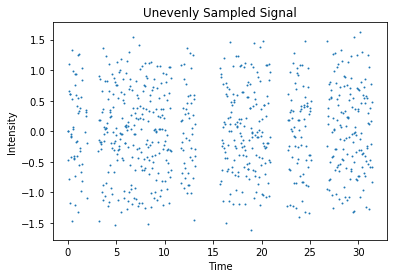

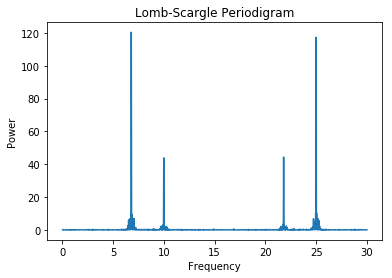

In [21]:
#Now to test the data when it is sampled with gaps

t = list(np.linspace(0, 10*np.pi, 1000))

#put together a new data set with gaps
t = t[0:49] + t[58:64] + t[100:341] + t[370:420] + t[500:666] + t[721:799] + t[850:]
t = np.asarray(t)
v = 0.5 * np.sin(2 * np.pi * 10 * t) + 0.8 * np.sin(2 * np.pi * 25 * t) + 0.2 * np.random.normal(size=t.size)

plt.figure(0)
plt.scatter(t, v, s=0.9)
plt.title('Unevenly Sampled Signal')
plt.xlabel('Time')
plt.ylabel('Intensity')

f_ls, v_ls = lomb_scargle(v, t, 4, f_max=30.)

plt.figure(2)
plt.plot(f_ls, v_ls)
plt.title('Lomb-Scargle Periodigram')
plt.xlabel('Frequency')
plt.ylabel('Power')

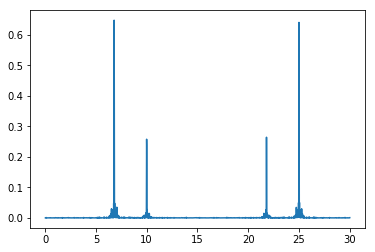

In [9]:
power = LombScargle(t, v).power(f_ls)

plt.plot(f_ls, power)

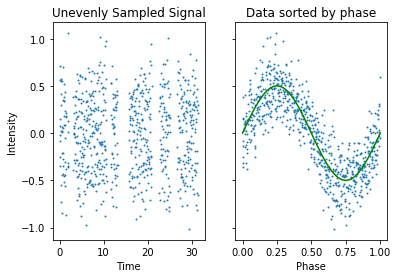

In [64]:
#Below is another example to show how the periodicity may be visualized

#To make this more simple, a single underlying wave was used
v = 0.5 * np.sin(2 * np.pi * 10 * t) + 0.2 * np.random.normal(size=t.size)
p_model = np.linspace(0,1,100)
v_model = 0.5 * np.sin(2 * np.pi * p_model)

phas = phase(t, 0.1)

f, ax = plt.subplots(1,2, sharey=True)
ax[0].scatter(t,v, s=0.9)
ax[0].set_title('Unevenly Sampled Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Intensity')
ax[1].scatter(phas, v, s=0.9)
ax[1].plot(p_model, v_model, color='g')
ax[1].set_title('Data sorted by phase')
ax[1].set_xlabel('Phase')

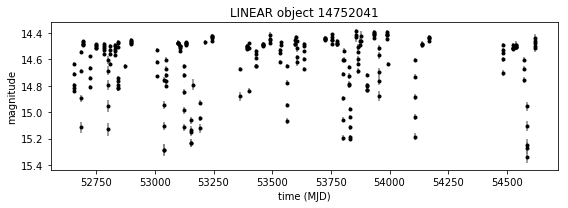

In [3]:
#Example data for opening slide

data = pd.read_csv('LINEAR_14752041.csv')


fig, ax = plt.subplots(figsize=(8, 3))
ax.errorbar(data.t, data.mag, data.magerr,
            fmt='.k', ecolor='gray', capsize=0)
ax.set(xlabel='time (MJD)',
       ylabel='magnitude',
       title='LINEAR object 14752041')
ax.invert_yaxis()

plt.tight_layout()
fig.savefig('fig01_LINEAR_data.png');

The higheset power peak is located at T= 0.364940796692
For similar data, this peak will be a false alarm  1.87623958408e-40 percent of the time.


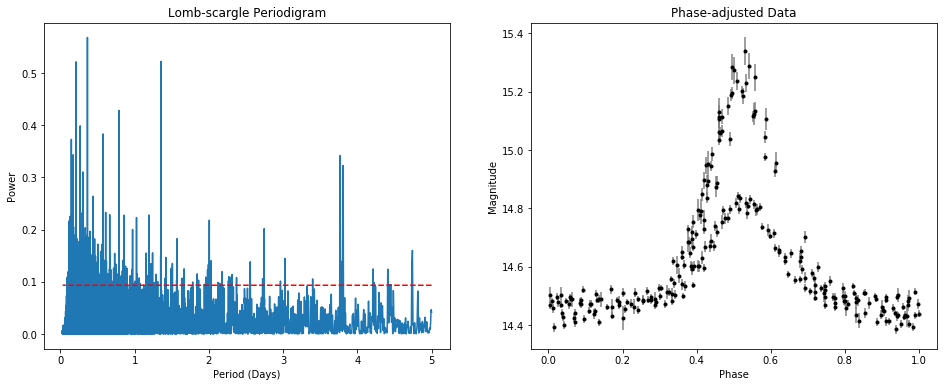

In [9]:
#Testing out Astropy's lomb-scargle tools

#Get the lomb-scargle parameters !These will be in frequency units!
ls = LombScargle(data.t, data.mag, data.magerr)
freq, power = ls.autopower(nyquist_factor=500,
                           minimum_frequency=0.2)

#Change to a period for more intuitive visualization
period = 1. / freq

#Find the most likely period
best_period = period[np.argmax(power)]
print("The higheset power peak is located at T=",  best_period)

#Find the significance of this peak
sig = ls.false_alarm_probability(np.amax(power))
print('For similar data, this peak will be a false alarm ', 
     sig*100, "percent of the time.")

#Let's do this in reverse, what peak height
#corresponds to a 0.05 false alarm?

p_level = ls.false_alarm_level(0.01)
p_level_array = np.full_like(period, p_level)

#Put together the phase diagram
pha = phase(data.t, best_period)

f, ax = plt.subplots(1,2)
ax[0].plot(period, power)
ax[0].plot(period, p_level_array, '--r')
ax[0].set_title('Lomb-scargle Periodigram')
ax[0].set_xlabel('Period (Days)')
ax[0].set_ylabel('Power')
ax[1].errorbar(pha, data.mag, data.magerr,
            fmt='.k', ecolor='gray', capsize=0)
ax[1].set_title('Phase-adjusted Data')
ax[1].set_xlabel('Phase')
ax[1].set_ylabel('Magnitude')
f.set_size_inches(16, 6)
f.savefig('astropy_periodogram.png')

